In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
batch_size=32

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import pandas as pd

# read in the CSV file
df = pd.read_csv('/content/drive/MyDrive/GAN_data.csv')

# create a mapping from characters to numbers
char_to_num = {char: i for i, char in enumerate(df['character'].unique())}
print(df['character'].unique())
# apply the mapping to the label column
df['character'] = df['character'].map(char_to_num)
print(df['character'].unique())
# save the modified dataframe back to the CSV file
df.to_csv('/content/drive/MyDrive/GAN_data_new.csv', index=False)

['character_01_ka' 'character_02_kha' 'character_03_ga' 'character_04_gha'
 'character_05_kna' 'character_06_cha' 'character_07_chha'
 'character_08_ja' 'character_09_jha' 'character_10_yna'
 'character_11_taamatar' 'character_12_thaa' 'character_13_daa'
 'character_14_dhaa' 'character_15_adna' 'character_16_tabala'
 'character_17_tha' 'character_18_da' 'character_19_dha' 'character_20_na'
 'character_21_pa' 'character_22_pha' 'character_23_ba' 'character_24_bha'
 'character_25_ma' 'character_26_yaw' 'character_27_ra' 'character_28_la'
 'character_29_waw' 'character_30_motosaw' 'character_31_petchiryakha'
 'character_32_patalosaw' 'character_33_ha' 'character_34_chhya'
 'character_35_tra' 'character_36_gya' 'digit_0' 'digit_1' 'digit_2'
 'digit_3' 'digit_4' 'digit_5' 'digit_6' 'digit_7' 'digit_8' 'digit_9']
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]


In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torchvision.transforms as transforms

class ImageDataset(Dataset):
    def __init__(self, csv_file, transform=None, subset=1.0):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.subset = subset

        if self.subset < 1.0:
            num_samples = int(len(self.data) * self.subset)
            indices = torch.randperm(len(self.data))[:num_samples]
            self.data = self.data.iloc[indices]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pixels = self.data.iloc[idx, :1024].values.astype('float32')
        image = torch.from_numpy(pixels).view(1, 32, 32) # assuming images are 32x32
        label = torch.tensor(self.data.iloc[idx, 1024])
        if self.transform:
            image = self.transform(image)
        return image, label

def add_rgb_channels(img):
    return torch.cat([img, img, img], dim=0)

# define your custom transforms
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((128,128)),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda img: add_rgb_channels(img))
])

# create your dataset with transforms and subset
my_dataset = ImageDataset('/content/drive/MyDrive/GAN_data_new.csv', transform=transform, subset=0.2)

# create your data loader with a subset sampler
batch_size = 32
train_loader = DataLoader(my_dataset, batch_size=batch_size, sampler=SubsetRandomSampler(range(len(my_dataset))))


In [ ]:
train_loader

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


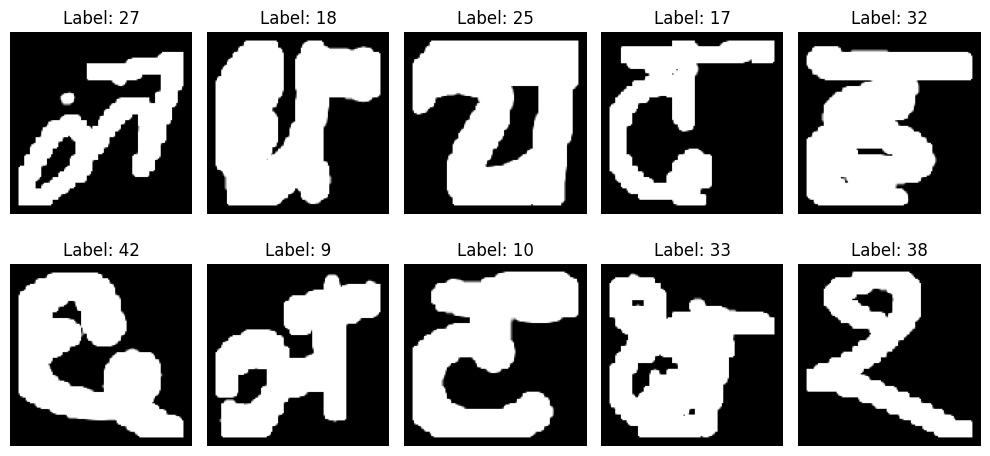

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

images, labels = next(iter(train_loader))

# convert images to 3 channels
# images = np.repeat(images, 3, axis=1)

# plot the images with their labels
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i in range(2):
    for j in range(5):
        idx = i * 5 + j
        axs[i, j].imshow(np.transpose(images[idx], (1, 2, 0)))
        axs[i, j].set_title(f"Label: {labels[idx]}")
        axs[i, j].axis('off')
plt.tight_layout()
plt.show()


In [ ]:
images, labels = next(iter(train_loader))
print(images.shape)

torch.Size([32, 3, 128, 128])


In [ ]:
len(train_loader)

575

In [ ]:
num_examples_to_generate = 50
latent_dim = 100
n_classes = 46
embedding_dim=100

In [ ]:
import torch.nn as nn
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()


        self.label_conditioned_generator =nn.Sequential(nn.Embedding(n_classes, embedding_dim),
                      nn.Linear(embedding_dim, 16))


        self.latent =nn.Sequential(nn.Linear(latent_dim, 4*4*512),
                                   nn.LeakyReLU(0.2, inplace=True))


        self.model =nn.Sequential(nn.ConvTranspose2d(513, 64*8, 4, 2, 1, bias=False),
                      nn.BatchNorm2d(64*8, momentum=0.1,  eps=0.8),
                      nn.ReLU(True),
                      nn.ConvTranspose2d(64*8, 64*4, 4, 2, 1,bias=False),
                      nn.BatchNorm2d(64*4, momentum=0.1,  eps=0.8),
                      nn.ReLU(True),
                      nn.ConvTranspose2d(64*4, 64*2, 4, 2, 1,bias=False),
                      nn.BatchNorm2d(64*2, momentum=0.1,  eps=0.8),
                      nn.ReLU(True),
                      nn.ConvTranspose2d(64*2, 64*1, 4, 2, 1,bias=False),
                      nn.BatchNorm2d(64*1, momentum=0.1,  eps=0.8),
                      nn.ReLU(True),
                      nn.ConvTranspose2d(64*1, 3, 4, 2, 1, bias=False),
                      nn.Tanh())

    def forward(self, inputs):
        noise_vector, label = inputs
        label_output = self.label_conditioned_generator(label)
        label_output = label_output.view(-1, 1, 4, 4)
        latent_output = self.latent(noise_vector)
        latent_output = latent_output.view(-1, 512,4,4)
        concat = torch.cat((latent_output, label_output), dim=1)
        image = self.model(concat)
        #print(image.size())
        return image

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()


        self.label_condition_disc =nn.Sequential(nn.Embedding(n_classes, embedding_dim),
                      nn.Linear(embedding_dim, 3*128*128))

        self.model =nn.Sequential(nn.Conv2d(6, 64, 4, 2, 1, bias=False),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64, 64*2, 4, 3, 2, bias=False),
                      nn.BatchNorm2d(64*2, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64*2, 64*4, 4, 3,2, bias=False),
                      nn.BatchNorm2d(64*4, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64*4, 64*8, 4, 3, 2, bias=False),
                      nn.BatchNorm2d(64*8, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Flatten(),
                      nn.Dropout(0.4),
                      nn.Linear(4608, 1),
                      nn.Sigmoid()
                     )

    def forward(self, inputs):
        img, label = inputs
        label_output = self.label_condition_disc(label)
        label_output = label_output.view(-1, 3, 128, 128)
        concat = torch.cat((img, label_output), dim=1)
        #print(concat.size())
        output = self.model(concat)
        return output

In [ ]:

binary_cross_entropy = nn.BCELoss()

In [ ]:
def generator_loss(label, fake_output):
    gen_loss = binary_cross_entropy(label, fake_output)
    #print(gen_loss)
    return gen_loss
def discriminator_loss(label, output):
    disc_loss = binary_cross_entropy(label, output)
    #print(total_loss)
    return disc_loss

In [ ]:
learning_rate=0.01
discriminator=Discriminator().to(device)
generator=Generator().to(device)
D_optimizer=torch.optim.SGD(discriminator.parameters(),lr=learning_rate)
G_optimizer=torch.optim.SGD(generator.parameters(),lr=learning_rate)

In [ ]:
from torch.autograd import Variable
num_epochs = 5
for epoch in range(1, num_epochs+1):
    print("Epoch: ",epoch)

    D_loss_list, G_loss_list = [], []

    for index, (real_images, labels) in enumerate(train_loader):
        D_optimizer.zero_grad()
        real_images = real_images.to(device)
        labels = labels.to(device)
        labels = labels.unsqueeze(1).long()


        real_target = Variable(torch.ones(real_images.size(0), 1).to(device))
        fake_target = Variable(torch.zeros(real_images.size(0), 1).to(device))

        D_real_loss = discriminator_loss(discriminator((real_images, labels)), real_target)
        # print(discriminator(real_images))
        #D_real_loss.backward()

        noise_vector = torch.randn(real_images.size(0), latent_dim, device=device)
        noise_vector = noise_vector.to(device)


        generated_image = generator((noise_vector, labels))
        output = discriminator((generated_image.detach(), labels))
        D_fake_loss = discriminator_loss(output,  fake_target)


        # train with fake
        #D_fake_loss.backward()

        D_total_loss = (D_real_loss + D_fake_loss) / 2
        D_loss_list.append(D_total_loss)

        D_total_loss.backward()
        D_optimizer.step()

        # Train generator with real labels
        G_optimizer.zero_grad()
        G_loss = generator_loss(discriminator((generated_image, labels)), real_target)
        G_loss_list.append(G_loss)

        G_loss.backward()
        G_optimizer.step()

Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5


In [ ]:
import torch
from torchvision.utils import save_image
from torchvision.transforms import ToPILImage

# Define the number of classes and the latent and embedding dimensions
n_classes = 46
latent_dim = 100
embedding_dim = 100
n_samples=10

# Set the generator to evaluation mode
generator.eval()

# Generate and save the images
to_pil = ToPILImage()
for c in range(n_classes):
    # Generate 50 noise vectors and labels for the current class
    noise_vectors = torch.randn(n_samples, latent_dim).to(device)
    labels = torch.tensor([c] * n_samples, dtype=torch.long).to(device)

    # Generate images from the noise vectors and labels
    with torch.no_grad():
        images = generator((noise_vectors, labels))

    # Save the images
    for i in range(n_samples):
        image = to_pil(images[i].cpu())
        image.save(f"/content/drive/MyDrive/GAN/class_{c}_image_{i}.png")


In [ ]:
import torch
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, data_path, transform):
        self.data_path = data_path
        self.transform = transform
        self.images = []
        self.labels = []
        for file_name in os.listdir(data_path):
            if file_name.endswith('.png'):
                file_path = os.path.join(data_path, file_name)
                class_label = int(file_name.split('_')[1])
                self.images.append(file_path)
                self.labels.append(class_label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path = self.images[index]
        label = self.labels[index]
        image = Image.open(image_path)
        image = self.transform(image)
        return image, label

# Define the path to the data folder and the batch size
data_path = "/content/drive/MyDrive/GAN"
batch_size = 32

# Define the transformations to be applied to the images
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the dataset using the CustomDataset class
dataset = CustomDataset(data_path=data_path, transform=transform)

# Create the DataLoader
test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Print the number of batches in the DataLoader
print(len(test_loader))


15


In [ ]:
images, labels = next(iter(test_loader))
print(images.shape)

torch.Size([32, 3, 128, 128])


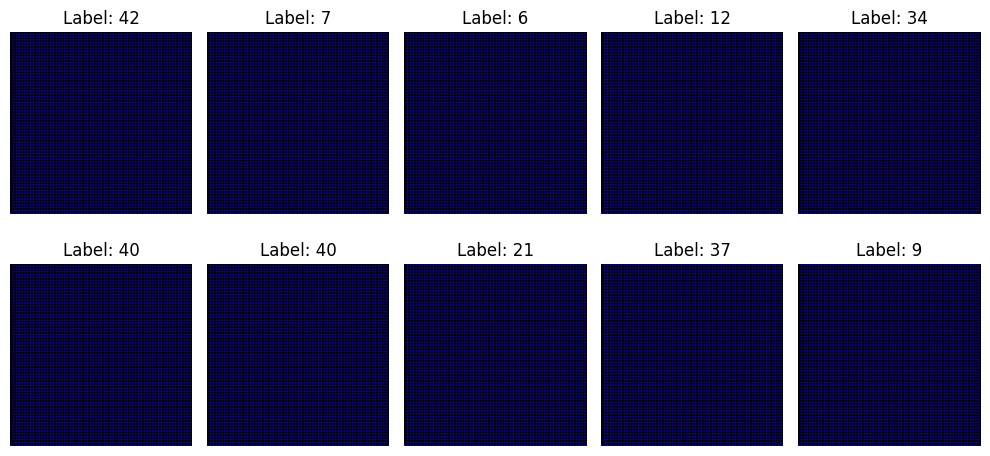

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

images, labels = next(iter(test_loader))

# convert images to 3 channels
# images = np.repeat(images, 3, axis=1)

# plot the images with their labels
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i in range(2):
    for j in range(5):
        idx = i * 5 + j
        axs[i, j].imshow(np.transpose(images[idx], (1, 2, 0)))
        axs[i, j].set_title(f"Label: {labels[idx]}")
        axs[i, j].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
import torchvision
classifier = torchvision.models.resnet18(pretrained=False,num_classes=46).to(device)
optimizer = torch.optim.SGD(classifier.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
train_loss_array = []
test_loss_array = []

In [ ]:
n_epochs=10
def train(epoch,classifier):
  classifier.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data,target=data.to(device),target.to(device)
    optimizer.zero_grad()
    output = classifier(data)
    loss = loss_function(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 300 == 0:
      print('Train Epoch: {}, Loss: {:.7f}'.format(epoch, loss.item()))
      train_loss_array.append(loss.item())
def test(classifier):
  classifier.eval()
  test_loss = 0
  corr = 0
  with torch.no_grad():
    for data, target in test_loader:
      data,target=data.to(device),target.to(device)
      output = classifier(data)
      loss_value=loss_function(output, target)
      test_loss += loss_value.item()
      pred = output.argmax(dim=1, keepdim=True)
      corr += pred.eq(target.data.view_as(pred)).sum().item()
  test_loss /= len(test_loader.dataset)
  test_loss_array.append(test_loss)
  print('\nTest set: Avg. loss: {:.5f}, Accuracy: {:.2f}%\n'.format(test_loss, 100. * corr / len(test_loader.dataset)))
for epoch in range(1, n_epochs + 1):
  train(epoch,classifier)
  test(classifier)

Train Epoch: 1, Loss: 0.4780883
Train Epoch: 1, Loss: 0.2725842

Test set: Avg. loss: 0.34098, Accuracy: 2.17%

Train Epoch: 2, Loss: 0.3186875
Train Epoch: 2, Loss: 0.2502702

Test set: Avg. loss: 0.32719, Accuracy: 2.17%

Train Epoch: 3, Loss: 0.1674585
Train Epoch: 3, Loss: 0.1782748

Test set: Avg. loss: 0.35271, Accuracy: 2.17%

Train Epoch: 4, Loss: 0.1323751
Train Epoch: 4, Loss: 0.1432994

Test set: Avg. loss: 0.36071, Accuracy: 2.17%

Train Epoch: 5, Loss: 0.0918889
Train Epoch: 5, Loss: 0.0695055

Test set: Avg. loss: 0.36250, Accuracy: 2.17%

Train Epoch: 6, Loss: 0.0816542
Train Epoch: 6, Loss: 0.0292554

Test set: Avg. loss: 0.34331, Accuracy: 2.17%

Train Epoch: 7, Loss: 0.0793388
Train Epoch: 7, Loss: 0.0383224

Test set: Avg. loss: 0.35880, Accuracy: 2.17%

Train Epoch: 8, Loss: 0.0284365
Train Epoch: 8, Loss: 0.0226978

Test set: Avg. loss: 0.33304, Accuracy: 2.17%

Train Epoch: 9, Loss: 0.0140480
Train Epoch: 9, Loss: 0.0323443

Test set: Avg. loss: 0.30412, Accuracy:

<Figure size 640x480 with 0 Axes>

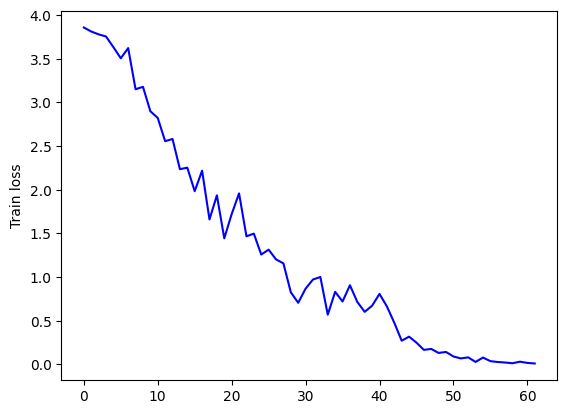

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(train_loss_array, color='blue')
plt.ylabel('Train loss')
plt.figure()

<Figure size 640x480 with 0 Axes>

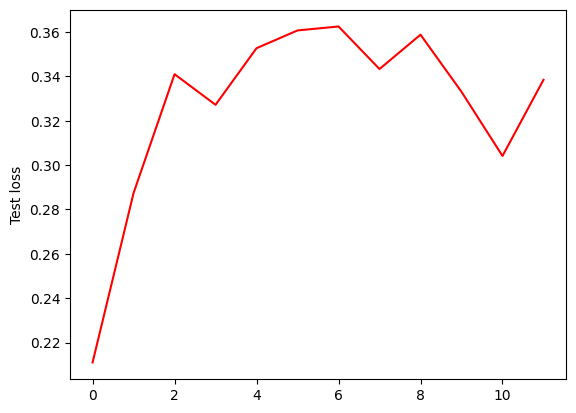

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(test_loss_array, color='red')
plt.ylabel('Test loss')
plt.figure()

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix
# Get the predictions from the model
y_pred = []
y_true = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = classifier(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred += predicted.cpu().tolist()
        y_true += labels.cpu().tolist()

# Calculate the F1 score for each class
f1_scores = f1_score(y_true, y_pred, average=None)

# Print the F1 score for each class
for i in range(len(f1_scores)):
    print(f"F1 score for class {i}: {f1_scores[i]:.4f}")


F1 score for class 0: 0.0000
F1 score for class 1: 0.0000
F1 score for class 2: 0.0000
F1 score for class 3: 0.0000
F1 score for class 4: 0.0000
F1 score for class 5: 0.0000
F1 score for class 6: 0.0000
F1 score for class 7: 0.0000
F1 score for class 8: 0.0000
F1 score for class 9: 0.0000
F1 score for class 10: 0.0000
F1 score for class 11: 0.0000
F1 score for class 12: 0.0000
F1 score for class 13: 0.0000
F1 score for class 14: 0.0000
F1 score for class 15: 0.0000
F1 score for class 16: 0.0000
F1 score for class 17: 0.0000
F1 score for class 18: 0.0000
F1 score for class 19: 0.0000
F1 score for class 20: 0.0000
F1 score for class 21: 0.0000
F1 score for class 22: 0.0000
F1 score for class 23: 0.0000
F1 score for class 24: 0.0000
F1 score for class 25: 0.0000
F1 score for class 26: 0.0000
F1 score for class 27: 0.0000
F1 score for class 28: 0.0000
F1 score for class 29: 0.0000
F1 score for class 30: 0.0000
F1 score for class 31: 0.0000
F1 score for class 32: 0.0000
F1 score for class 3

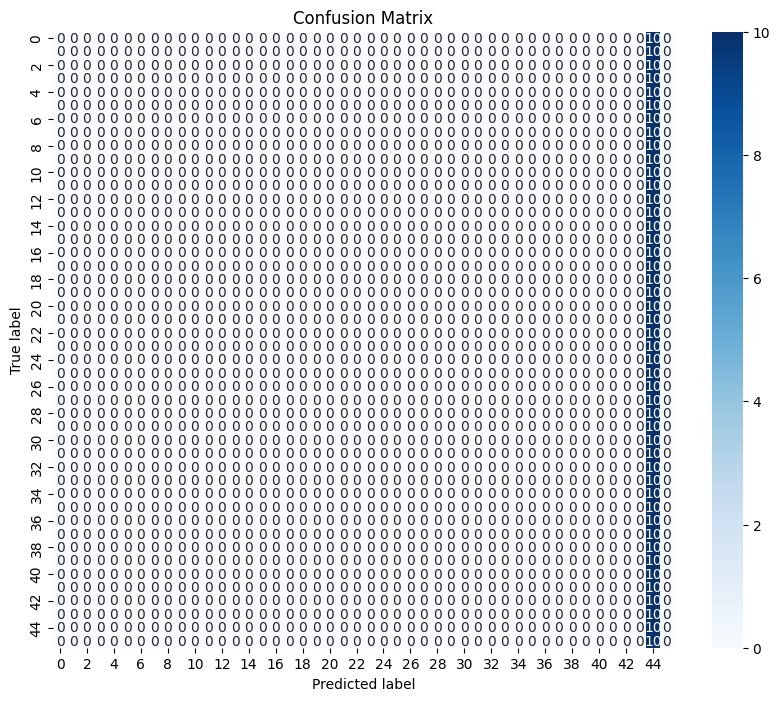

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()
# # Print the confusion matrix
# print("Confusion matrix:")
# print(conf_matrix)